# PostAnalysis for sequencing of Merfish oligo pool

by Pu Zheng

2023.11.21

In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

3972947


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
data_folder = r'/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/'
analysis_folder = os.path.join(data_folder, 'Analysis')

# load probes

In [5]:
# Load probes:
from Bio import SeqIO

probe_filename = os.path.join(analysis_folder, 'Merged_probes.fasta')
print(probe_filename)

probes = []
for record in SeqIO.parse(probe_filename, "fasta"):
    probes.append(record)
print(len(probes))

/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/Analysis/Merged_probes.fasta
168400


In [6]:
probe_df = pd.DataFrame({
    'name':[ _pb.name for _pb in probes],
    'sequence': [str(_pb.seq) for _pb in probes],
})
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
168395,fwd_W1B09_primer_20_target_Position23_RNF2_BC7...,TAGGCGTGTCGGCCAACCAGtaACCTGTCTTGGAGTAATGACtaCC...
168396,fwd_W1B09_primer_20_target_Position24_RNF2_BC8...,TAGGCGTGTCGGCCAACCAGtaACCTGTCGGAGTGTAATGACtaAT...
168397,fwd_W1B09_primer_20_target_Position0_EMX1_uned...,TAGGCGTGTCGGCCAACCAGtaTGGGAGCCCAAGTTCTTCTGtaAC...
168398,fwd_W1B09_primer_20_target_Position0_HEK3_uned...,TAGGCGTGTCGGCCAACCAGtaTCTGCCAAGTCGTGCTCAGTtaAA...


In [42]:
# load analysis 
sequence_folder = os.path.join(data_folder, '20240110_071743', 'Fastq')
alignment_stats = [os.path.join(sequence_folder, _f) for _f in os.listdir(sequence_folder) if '.idxstats' in _f]
alignment_stats

['/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Undetermined_S0_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Twist-MF4-DNA_S4_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/PCR-MF5_S8_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Amplified-MF4-DNA_S6_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Amplified-24edits_S10_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Amplified-MF4-16bit_S3_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/20240110_071743/Fastq/Twist-MF5_S7_L001.idxstats',
 '/lab/solexa_weissman/PEtracing_shared/240109_Pu_MF_Probe_libs/Alignment_1/202

## MO4

In [18]:
amplified_pool_stat

,ref,length,mapped,unmapped
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,150,0,0
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,150,0,0
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,150,0,0
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,150,0,0
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,150,0,0
...,...,...,...,...
168396,fwd_W1B09_primer_20_target_Position24_RNF2_BC8...,152,1,0
168397,fwd_W1B09_primer_20_target_Position0_EMX1_uned...,152,1,0
168398,fwd_W1B09_primer_20_target_Position0_HEK3_uned...,152,1,0
168399,fwd_W1B09_primer_20_target_Position0_RNF2_uned...,152,6,0


In [31]:
lib_probe_df

,name,sequence
127389,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGAGGGTTTGTAAGGTGAATATGGGTG...
127390,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGTGGGAGGATTGAGATGAGTTTGGGTG...
127391,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTTGGGA...
127392,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTGAGGG...
127393,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTATCGA...
...,...,...
139116,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGATAGGAAATGGTGGTAGTGTTAGATC...
139117,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGATAGGAAATGGTGGTAGTGTTAGAGT...
139118,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGGGGATGTATTGAAGGAGGATTTGACC...
139119,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGGGGATGTATTGAAGGAGGATTAGAGT...


In [63]:
np.sum(library_kept_flag)

11732

In [72]:
library_name = 'MF4-16bit'#'MF4-16bit'
library_probe_name = 'MF4-4T1Primary16bit'

library_kept_flag = [library_probe_name == _n.split('_')[0] for _n in probe_df['name']]
lib_probe_df = probe_df.loc[np.array(library_kept_flag)]


amplified_pool_stat = pd.read_table([_f for _f in alignment_stats 
                                     if library_name in _f and 'amplified' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])

lib_amplified_match_df = amplified_pool_stat.loc[
    np.array(library_kept_flag + [False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(11732, 1680909, 2906)

In [73]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)


(143.24795431299012, 0.0)

In [77]:
lib_amplified_match_df

,ref,length,mapped,unmapped,name,sequence
127389,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,133,201,0,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGAGGGTTTGTAAGGTGAATATGGGTG...
127390,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,133,237,0,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGTGGGAGGATTGAGATGAGTTTGGGTG...
127391,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,133,295,0,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTTGGGA...
127392,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,133,301,0,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTGAGGG...
127393,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,133,143,0,MF4-4T1Primary16bit_Klrk1_ENSMUST00000032252.8...,CCCGCAATGGCTGACAACCGGGGTGGTTTAGTGTGTGTTTTATCGA...
...,...,...,...,...,...,...
139116,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,133,151,0,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGATAGGAAATGGTGGTAGTGTTAGATC...
139117,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,133,325,0,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGATAGGAAATGGTGGTAGTGTTAGAGT...
139118,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,133,61,0,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGGGGATGTATTGAAGGAGGATTTGACC...
139119,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,133,101,0,MF4-4T1Primary16bit_Klhl14_ENSMUST00000122333....,CCCGCAATGGCTGACAACCGGGGATGTATTGAAGGAGGATTAGAGT...


In [78]:
np.sum(lib_amplified_match_df['mapped']==0)

0

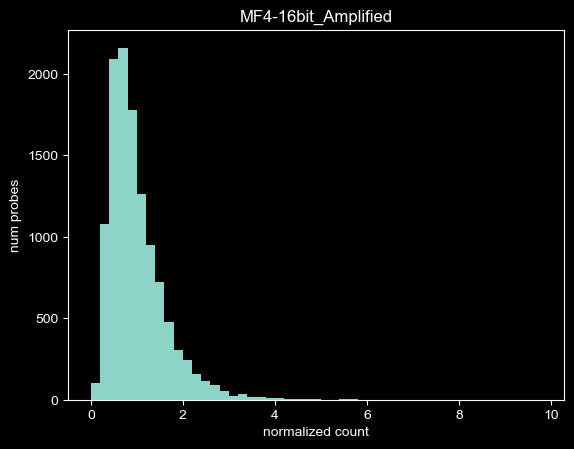

In [79]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [80]:
lib_amplified_match_df['name'].values[0].split('_')[1]

'Klrk1'

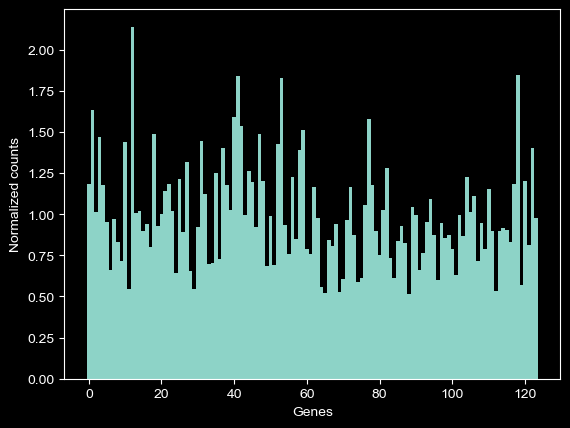

In [81]:
# split by gene
gene_2_amplified_match_df = {}
for _i, _row in lib_amplified_match_df.iterrows():
    _gene = _row['name'].split('_')[1]
    #print(_gene)
    if _gene not in gene_2_amplified_match_df:
        gene_2_amplified_match_df[_gene] = [_row['mapped']]
    else:
        gene_2_amplified_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_amplified_match_df['mapped'])/len(_v) for _v in gene_2_amplified_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

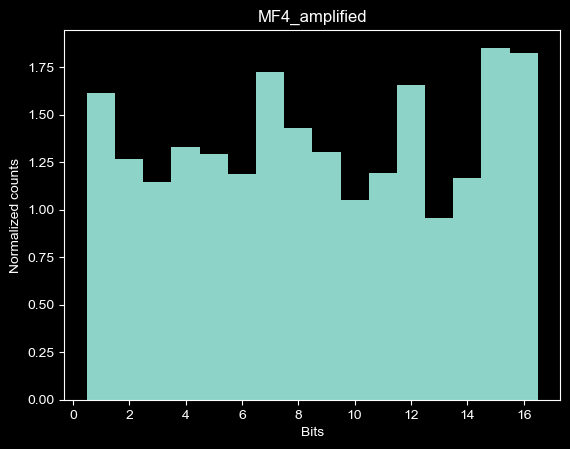

In [53]:
# split by probe
probe_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_amplified_matches:
        probe_2_amplified_matches[_probe] = [_row['mapped']]
    else:
        probe_2_amplified_matches[_probe].append(_row['mapped'])
#probes = [_k for _k in sorted(probe_2_amplified_matches.keys(), key=lambda v:int(v.split('_')[1]))]
#probe_total_counts = [np.sum(probe_2_amplified_matches[_p])/np.mean(lib_amplified_match_df['mapped'])/len(probe_2_amplified_matches[_p]) 
#                      for _p in probes]

import re
res = re.findall(r'(RS[0-9]+)', lib_amplified_match_df['name'].values[0])
readouts_2_amplified_pbs = {}
for _ir, _row in lib_amplified_match_df.iterrows():
    _ct = _row['mapped']
    _readouts = re.findall(r'(RS[0-9]+)', _row['name'])
    for _r in _readouts:
        if _r not in readouts_2_amplified_pbs:
            readouts_2_amplified_pbs[_r] = _ct
        else:
            readouts_2_amplified_pbs[_r] += _ct
            
probe_total_counts = [_v *22 / np.sum(list(readouts_2_amplified_pbs.values())) for _k,_v in sorted(readouts_2_amplified_pbs.items())][:22]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

## MF3 PCR


In [54]:

lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_twist_match_df = pd.concat([lib_twist_match_df, lib_probe_df], axis=1)
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(23482, 602121, 3441)

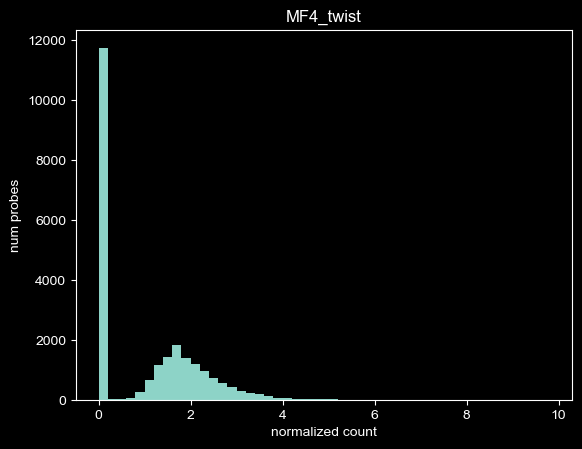

In [55]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_twist")
plt.show()

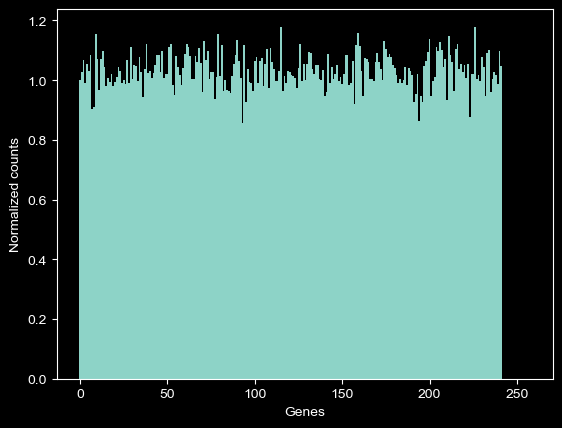

In [71]:
# split by gene
gene_2_twist_match_df = {}
for _i, _row in lib_twist_match_df.iterrows():
    _gene = _row['name'].split('_')[3]
    #print(_gene)
    if _gene not in gene_2_twist_match_df:
        gene_2_twist_match_df[_gene] = [_row['mapped']]
    else:
        gene_2_twist_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_twist_match_df['mapped'])/len(_v) for _v in gene_2_twist_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_twist_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

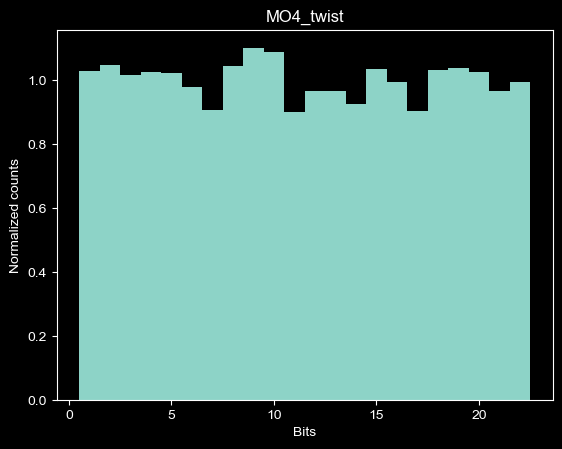

In [72]:
# split by probe
probe_2_twist_matches = {}
for _i, _row in lib_twist_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_twist_matches:
        probe_2_twist_matches[_probe] = [_row['mapped']]
    else:
        probe_2_twist_matches[_probe].append(_row['mapped'])
#probes = [_k for _k in sorted(probe_2_twist_matches.keys(), key=lambda v:int(v.split('_')[1]))]
#probe_total_counts = [np.sum(probe_2_twist_matches[_p])/np.mean(lib_twist_match_df['mapped'])/len(probe_2_twist_matches[_p]) 
#                      for _p in probes]

import re
res = re.findall(r'(RS[0-9]+)', lib_twist_match_df['name'].values[0])
readouts_2_twist_pbs = {}
for _ir, _row in lib_twist_match_df.iterrows():
    _ct = _row['mapped']
    _readouts = re.findall(r'(RS[0-9]+)', _row['name'])
    for _r in _readouts:
        if _r not in readouts_2_twist_pbs:
            readouts_2_twist_pbs[_r] = _ct
        else:
            readouts_2_twist_pbs[_r] += _ct
            
probe_total_counts = [_v *22 / np.sum(list(readouts_2_twist_pbs.values())) for _k,_v in sorted(readouts_2_twist_pbs.items())][:22]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_twist")
#for _gene, _counts in gene_2_twist_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

# 24 Edits

In [83]:
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
168395,fwd_W1B09_primer_20_target_Position23_RNF2_BC7...,TAGGCGTGTCGGCCAACCAGtaACCTGTCTTGGAGTAATGACtaCC...
168396,fwd_W1B09_primer_20_target_Position24_RNF2_BC8...,TAGGCGTGTCGGCCAACCAGtaACCTGTCGGAGTGTAATGACtaAT...
168397,fwd_W1B09_primer_20_target_Position0_EMX1_uned...,TAGGCGTGTCGGCCAACCAGtaTGGGAGCCCAAGTTCTTCTGtaAC...
168398,fwd_W1B09_primer_20_target_Position0_HEK3_uned...,TAGGCGTGTCGGCCAACCAGtaTCTGCCAAGTCGTGCTCAGTtaAA...


In [85]:
library_name = '24edits'#'MF4-16bit'
library_probe_name = 'fwd'

library_kept_flag = [library_probe_name == _n.split('_')[0] for _n in probe_df['name']]
lib_probe_df = probe_df.loc[np.array(library_kept_flag)]


amplified_pool_stat = pd.read_table([_f for _f in alignment_stats 
                                     if library_name in _f and 'amplified' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])

lib_amplified_match_df = amplified_pool_stat.loc[
    np.array(library_kept_flag + [False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(27, 1726415, 2009)

In [106]:
lib_amplified_match_df.loc[168373, 'ref',]

'fwd_W1B09_primer_20_target_Position1_HEK3_BC1_CTATC_readouts_4xR25__NDB_643_rev_W1B10_primer_21'

In [86]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)


(63928.555555555555, 0.0)

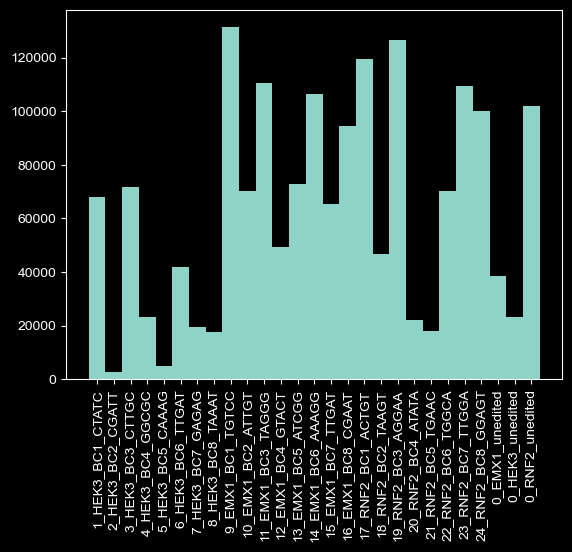

In [110]:
plt.figure()
plt.bar(np.arange(len(lib_amplified_match_df)), height=lib_amplified_match_df['mapped'],width=1,
        )
plt.xticks(np.arange(len(lib_amplified_match_df)), 
          [_r.split('target_Position')[1].split('_readouts')[0] for _r in lib_amplified_match_df['ref']],
          rotation=90)
plt.show()

In [112]:
lib_amplified_match_df.to_csv(os.path.join(analysis_folder, '24edit_analyzed.csv'))